In [1]:
 import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learning import ReachingTask

In [2]:
# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

In [7]:
filename = 'learning-env1-0-0-0-0'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
state_ctx = data['state_ctx']
state_d1 = data['state_d1']

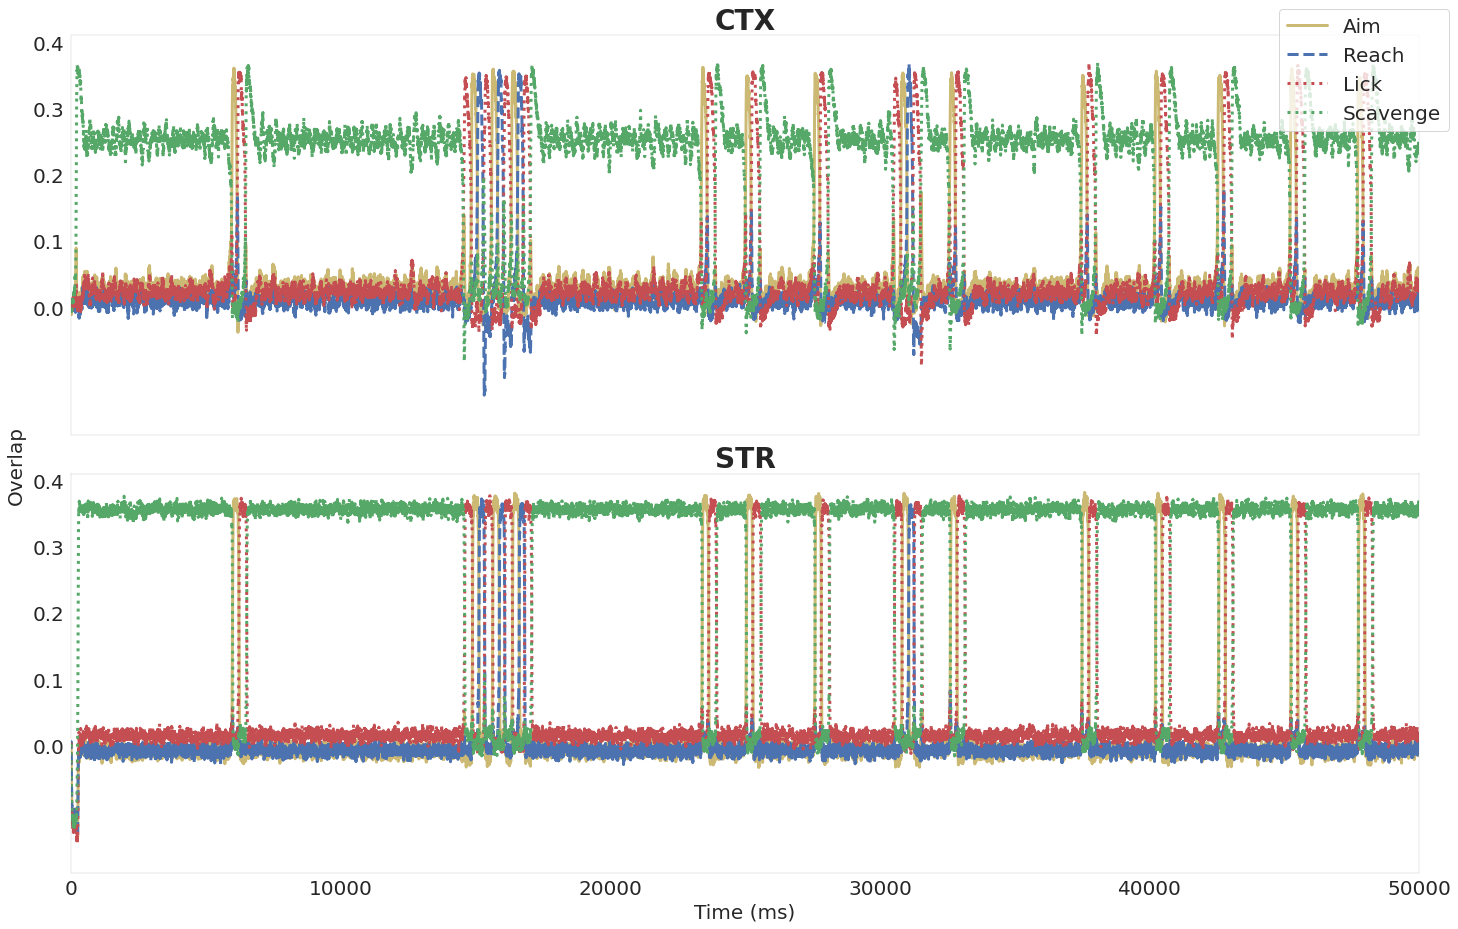

In [9]:
### Overlap 
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=28, weight='bold')
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=28, weight='bold')
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 50000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick', 'Scavenge'], fontsize=20)
# plt.savefig('/work/jp464/striatum-sequence/output/constant-env-pathological.jpg', bbox_inches = "tight", format='jpg')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: './output/learning-env0-0-0-0-0-raster.svg'

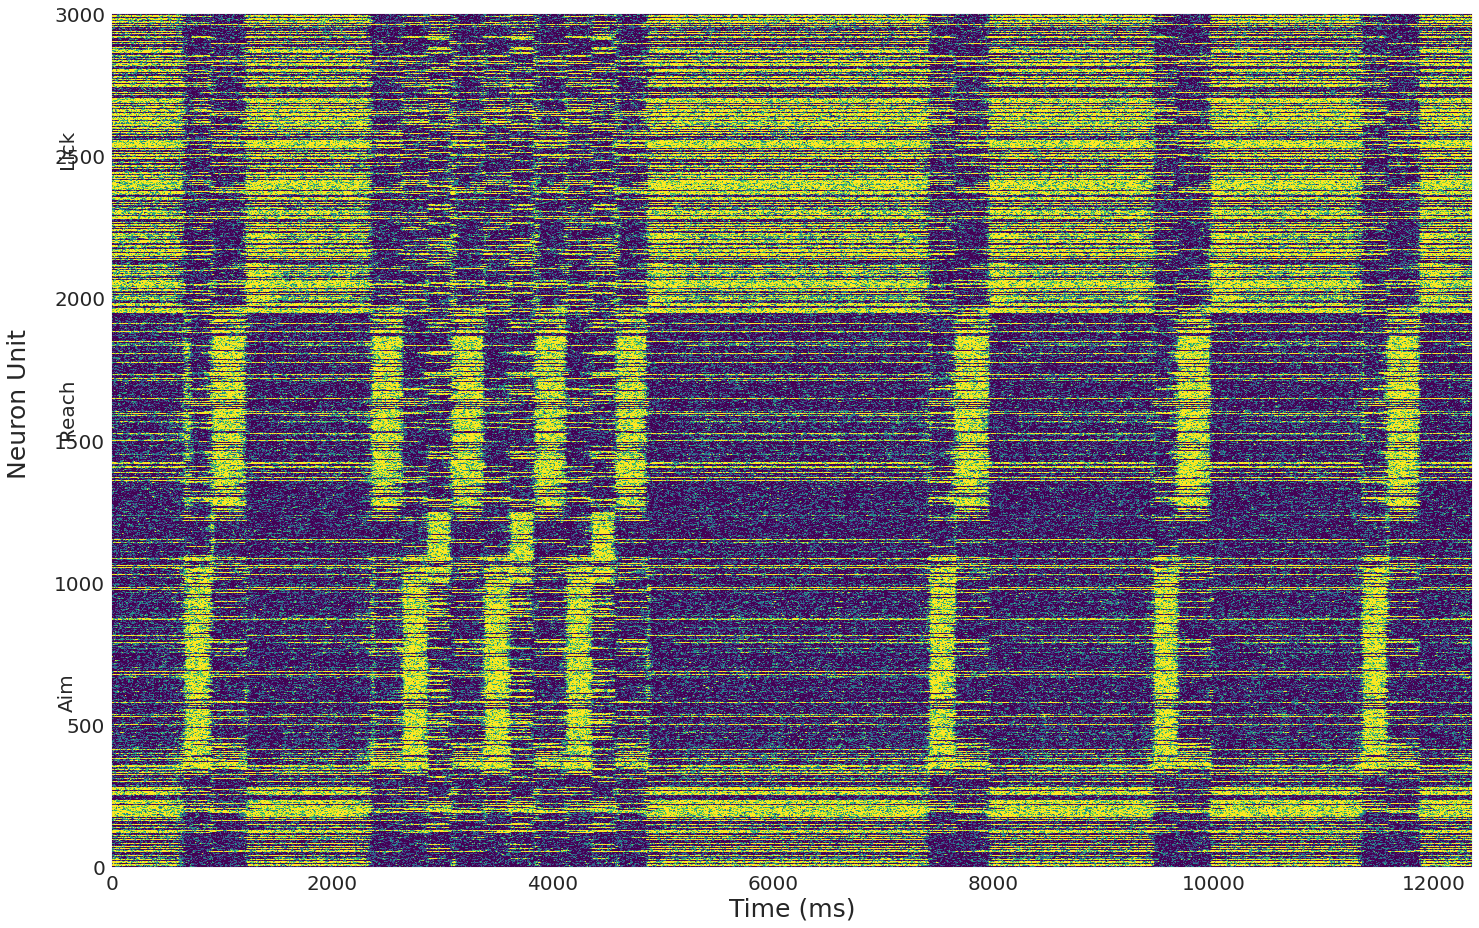

In [5]:
### Raster plot 
fig, axes = plt.subplots(sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
idxs = np.argsort([np.argmax(r) for r in state_ctx[:,57100:58800]])
idxs = [i for i in idxs if state_ctx[:,57100:58800][i].max() > 0.00]
temp = state_ctx[:,40000:52350]
axes.pcolormesh(temp[idxs], vmin=0.0, vmax=1.0, cmap='viridis', rasterized=True)
axes.set_xlabel('Time (ms)', fontsize=25)
fig.text(0.01, 0.24, 'Aim', rotation='vertical', fontsize=20)
fig.text(0.01, 0.53, 'Reach', rotation='vertical', fontsize=20)
fig.text(0.01, 0.82, 'Lick', rotation='vertical', fontsize=20)
fig.text(-.025, .49, 'Neuron Unit', rotation='vertical', fontsize=25)
plt.savefig('./output/' + filename + '-raster' + '.svg', bbox_inches="tight", format='svg')
plt.show()

In [ ]:
### Learning rate 
fig, axes = plt.subplots(sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
mouse = ReachingTask(3, alpha=0.5)
performance = mouse.learning_performance(overlaps_bg, 180000)
axes.plot(performance, linewidth=3)
axes.set_xlabel('Session')
axes.set_ylabel('Reward rate (unit/s)')
plt.savefig('./output/' + filename + '-performance' + '.svg', bbox_inches='tight', format='svg')
plt.show()